In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim


class Attention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.d_k = d_k

    def forward(self, Q, K, V):
        """
        Input of dim: [batch, time_dim, input_dim]
        """

        output = torch.zeros_like(Q)

        # should be vectorized, keeping it like this for simplicity
        for b in range(Q.size()[0]):
            v = Q[b] @ K[b].T / math.sqrt(self.d_k)
            v = F.softmax(v, dim=1)
            v = v @ V[b]
            output[b] = v

        return output

    
class GELU(nn.Module):
    """
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

In [31]:
class Block(nn.Module):
    def __init__(self, dim_size, device="cuda"):
        super().__init__()
        self.attention = Attention(d_k=dim_size)
        self.linear = nn.Linear(dim_size, dim_size, device=device)
        self.norm = GELU()

    def forward(self, X):
        v = self.attention(X, X, X)
        v = self.norm(X + v)

        linear_list = []
        # should be vectorized, keeping it like this for simplicity
        for b in range(X.size(0)):
            linear_list.append(self.linear(v[b]).unsqueeze(0))
        v = torch.concat(linear_list)

        v = self.norm(v)

        return v

In [32]:
class Transformer(nn.Module):
    def __init__(self, num_blocks, in_dim, feature_dim):
        super().__init__()
        self.blocks = []
        for _ in range(num_blocks):
            self.blocks.append(Block(feature_dim))

        self.feature_dim = feature_dim
        self.input_linear = nn.Linear(in_dim, feature_dim)
        self.output_linear = nn.Linear(feature_dim, 1)

    def forward(self, x):
        """
        Input of dim: [batch, time_dim, input_dim]
        """
        v = torch.zeros(x.size(0), x.size(1), self.feature_dim, dtype=torch.float32, device=x.device)

        linear_list = []
        # should be vectorized, keeping it like this for simplicity
        for b in range(x.size(0)):
            linear_list.append(self.input_linear(x[b]).unsqueeze(0))
        v = torch.concat(linear_list)

        for block in self.blocks:
            v = block(v)

        v = torch.mean(v, dim=1)
        o = self.output_linear(v)

        return o

In [33]:
model = Transformer(num_blocks=2, in_dim=1, feature_dim=64).to("cuda")

X = torch.rand(2, 5, 1).to("cuda")
o = model.forward(X)
o.shape

torch.Size([2, 1])

In [34]:
def function_to_approximate(t):
    return 3 * np.sin(10 * t) - 2 * np.cos(-1 * t) + np.sin(10 * t) * np.cos(5 * t)


def generate_sample(max_time_diff, time_size):
        diff = np.random.uniform(0, max_time_diff)
        start = np.random.randint(0, 10)

        t = diff * (start + np.arange(0, time_size))

        y = function_to_approximate(t)
        y = y + np.random.normal(0.0, 0.1, size=time_size)
        return t, y


class WaveDataset(Dataset):
    def __init__(self, max_time_diff=1.0, num_samples_per_batch=1024, time_size=16):
        self.num_samples_per_batch = num_samples_per_batch
        self.max_time_diff = max_time_diff
        self.time_size = time_size

    def __len__(self):
        return self.num_samples_per_batch
    
    def __getitem__(self, _):
        _, samples = generate_sample(self.max_time_diff, self.time_size)
        samples = torch.from_numpy(samples)

        x = samples[0:(self.time_size - 1)].unsqueeze(1).type(torch.float32)

        # predict the last samples
        y = samples[self.time_size - 1].unsqueeze(-1).type(torch.float32)
        return x, y

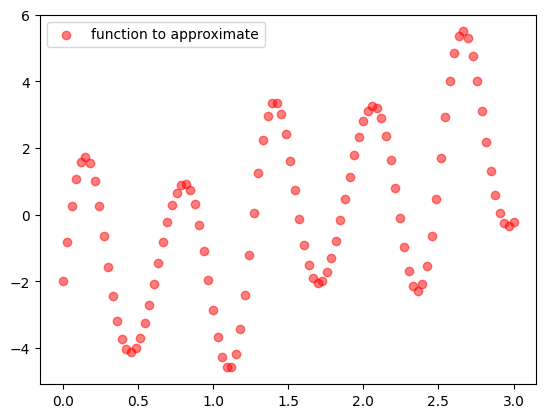

In [35]:
t_gt = np.linspace(0, 3.0, num=100)
y_gt = function_to_approximate(t_gt)

plt.scatter(t_gt, y_gt, c="r", label="function to approximate", alpha=0.5)
plt.legend()
plt.show()

In [36]:
batch_size = 128
train_dataset = WaveDataset()
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0)

val_dataset = WaveDataset()
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)

In [37]:
seed = 42
num_epochs = 20
lr = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [38]:
np.random.seed(seed)
torch.manual_seed(seed)

for epoch in range(num_epochs):
    train_loss = 0.0

    model.train()
    for _, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()

        x = x.to("cuda")
        y = y.to("cuda")

        y_hat = model(x)
        batch_loss = F.mse_loss(y_hat, y)
        batch_loss.backward()
        optimizer.step()

        batch_loss = batch_loss.detach().cpu().numpy()
        train_loss += batch_loss / len(y)

    train_loss = train_loss / len(train_dataloader)

    val_loss = 0.0

    model.eval()
    for _, (x, y) in enumerate(val_dataloader):
        x = x.to("cuda")
        y = y.to("cuda")

        y_hat = model(x)
        batch_loss = F.mse_loss(y_hat, y)

        batch_loss = batch_loss.detach().cpu().numpy()
        val_loss += batch_loss / len(y)

    val_loss = val_loss / len(val_dataloader)

    if epoch % 5 == 0 or epoch == (num_epochs - 1):
        print(f"----------- Epoch {epoch} -----------")
        print(f"Train loss: {train_loss}")
        print(f"Val loss: {val_loss}")

----------- Epoch 0 -----------
Train loss: 0.05088800564408302
Val loss: 0.053375903982669115
----------- Epoch 5 -----------
Train loss: 0.05261254357174039
Val loss: 0.05594276450574398
----------- Epoch 10 -----------
Train loss: 0.05131073668599129
Val loss: 0.0525585999712348
----------- Epoch 15 -----------
Train loss: 0.050508211832493544
Val loss: 0.04992994898930192
----------- Epoch 19 -----------
Train loss: 0.05215902952477336
Val loss: 0.054550386033952236
